Shopper Segmentations
--

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
contributions_file = '20190818_Contributions.csv'
batches_file = '20190722_20190818_Batches.csv'
metrics_file = '20190818_Metrics.csv'
save_file = '20190722_20190818_Shoppers.csv'
save_contribution_file = '20190818_Contribution_Scores.csv'
period_lastday = datetime(2019, 8, 18).date()

In [3]:
batches = pd.read_csv(batches_file)
metrics = pd.read_csv(metrics_file)
contributions = pd.read_csv(contributions_file)

### Contribution Score

In [4]:
contributions.head(3)

,shopper_id,batch_date,zone_id,hour_of_day,running_total_batches,tenure_in_days,activation_day,daily_batch,zone_tot_batch
0,89,2013-01-29,1,17.0,2.0,0.0,2013-01-29,1.0,50.0
1,89,2013-01-29,1,20.0,2.0,0.0,2013-01-29,1.0,50.0
2,89,2013-01-31,1,16.0,4.0,2.0,2013-01-29,1.0,45.0


In [5]:
# Get Shopper Tenure Days to Last Day of Analysis.
tenures = contributions[['shopper_id', 'activation_day']].drop_duplicates()
tenures['activation_day'] = pd.to_datetime(tenures['activation_day'], infer_datetime_format=True)
tenures['activation_day'] = tenures['activation_day'].map(lambda x: x.date())
tenures['tenure'] = tenures['activation_day'].map(lambda x: (period_lastday - x).days + 1)

In [6]:
tenures.head(3)

,shopper_id,activation_day,tenure
0,89,2013-01-29,2393.0
4430,100,2013-02-09,2382.0
8402,135,2013-04-10,2322.0


In [7]:
# Get contribution score for each record
contributions['contribution_score'] = contributions['daily_batch'] / contributions['zone_tot_batch']
contribution_scores = contributions[['shopper_id', 'contribution_score']].groupby(['shopper_id'])\
    .sum().reset_index()

# Get contribution score normalized by tenure days.
contribution_scores = contribution_scores.merge(tenures, on=['shopper_id'])
contribution_scores['contribution_normed'] = contribution_scores['contribution_score'] * 100\
    / contribution_scores['tenure']

# The contribition score can be very high for shoppers with 1 or 2 days of tenure. 
# Only consider Shoppers with tenure days >= 7 days.
contribution_scores = contribution_scores[contribution_scores['tenure'] > 7]

In [8]:
contribution_scores.head(3)

,shopper_id,contribution_score,activation_day,tenure,contribution_normed
0,89,7.756465,2013-01-29,2393.0,0.324131
1,100,11.965103,2013-02-09,2382.0,0.502313
2,135,12.015017,2013-04-10,2322.0,0.517443


In [9]:
contribution_scores['contribution_normed'].min()

0.00023245624002439166

In [10]:
contribution_scores['contribution_normed'].max()

73.733091132792993

In [11]:
contribution_scores[contribution_scores['contribution_normed'] > 70]

,shopper_id,contribution_score,activation_day,tenure,contribution_normed
19550,898406,408.481325,2018-02-11,554.0,73.733091
97521,3187708,118.559942,2019-03-05,167.0,70.993977


In [12]:
contributions[contributions['shopper_id'] == 898406].tail(10)

,shopper_id,batch_date,zone_id,hour_of_day,running_total_batches,tenure_in_days,activation_day,daily_batch,zone_tot_batch,contribution_score
14288501,898406,2019-08-16,797,13.0,2274.0,551.0,2018-02-11,1.0,9.0,0.111111
14288502,898406,2019-08-16,797,17.0,2274.0,551.0,2018-02-11,1.0,9.0,0.111111
14288503,898406,2019-08-16,797,19.0,2274.0,551.0,2018-02-11,1.0,9.0,0.111111
14288504,898406,2019-08-17,797,8.0,2276.0,552.0,2018-02-11,1.0,10.0,0.100000
14288505,898406,2019-08-17,797,12.0,2276.0,552.0,2018-02-11,1.0,10.0,0.100000
14288506,898406,2019-08-18,797,10.0,2282.0,553.0,2018-02-11,2.0,20.0,0.100000
14288507,898406,2019-08-18,797,13.0,2282.0,553.0,2018-02-11,1.0,20.0,0.050000
14288508,898406,2019-08-18,797,15.0,2282.0,553.0,2018-02-11,1.0,20.0,0.050000
14288509,898406,2019-08-18,797,17.0,2282.0,553.0,2018-02-11,1.0,20.0,0.050000
14288510,898406,2019-08-18,797,19.0,2282.0,553.0,2018-02-11,1.0,20.0,0.050000


#### contribution tier

In [13]:
contribution_scores['contribution_tier'] = contribution_scores['contribution_normed']\
                                                  .map(lambda x: 1 if x <= 0.02 else
                                                                 2 if x <= 0.05 else
                                                                 3 if x <= 0.1 else
                                                                 4 if x <= 0.2 else
                                                                 5 if x <= 0.5 else
                                                                 6 if x <= 1.0 else
                                                                 7 if x <= 2.0 else
                                                                 8 if x <= 5.0 else
                                                                 9 if x <= 10.0 else
                                                                 10)

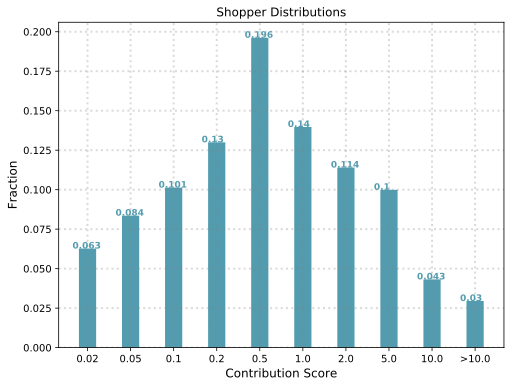

In [14]:
ind_width = 0.4

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
contribution_tier = contribution_scores[['contribution_tier', 'shopper_id']]\
    .groupby('contribution_tier').count().reset_index()\
    .rename(columns={'shopper_id':'shopper_count'})
tot_shopper = len(contribution_scores)
y = [i / float(tot_shopper) for i in contribution_tier['shopper_count'].tolist()][:10]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Contribution Score',fontsize=12)
ax1.set_ylabel('Fraction',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('0.02', '0.05', '0.1', '0.2',
                     '0.5', '1.0', '2.0', '5.0', '10.0',
                    '>10.0'))
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=9)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

### Batches

In [15]:
batches.head(3)

,shopper_id,batch_date,channel_simplified,applied_role,worked_role,running_total_batches,tenure_in_days,zone_size,zone_mode,region_size,applied_day,ready_to_activate_day,activation_day,on_demand_batches,full_service_batches,delivery_only_batches,picking_only_batches,pickup_batches,other_batches,total_batches
0,2378996,2019-08-13,organic,FSS,NaN,NaN,NaN,2001 - 5000,hybrid,10k+,2018-10-03,2019-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5573575,2019-08-03,referral,FSS,NaN,NaN,NaN,2001 - 5000,hybrid,3001 - 10k,2019-06-29,2019-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4664730,2019-08-09,paid,FSS,NaN,NaN,NaN,201 - 500,hybrid,0 - 500,2019-06-14,2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Select the last batch for each shopper during this 28 days.

batches.dropna(subset=['total_batches'], inplace=True)

# Get batches in this 28 days
batches_28 = batches[['shopper_id', 'total_batches']].groupby('shopper_id')\
    .sum().reset_index().rename(columns={'total_batches':'t28_batches'})

# Join dataframe
batches = batches.sort_values(by=['shopper_id', 'batch_date']).groupby('shopper_id').tail(1)
batches = batches.merge(batches_28, on=['shopper_id'])

In [17]:
batches[batches['shopper_id'] == 89]

,shopper_id,batch_date,channel_simplified,applied_role,worked_role,running_total_batches,tenure_in_days,zone_size,zone_mode,region_size,...,ready_to_activate_day,activation_day,on_demand_batches,full_service_batches,delivery_only_batches,picking_only_batches,pickup_batches,other_batches,total_batches,t28_batches
0,89,2019-08-18,NaN,NaN,FSS,4903.0,2392.0,5000+,hybrid,10k+,...,NaN,2013-01-29,1.0,NaN,NaN,NaN,NaN,NaN,1.0,40.0


In [18]:
# Get Activation days
batches['applied_day'] = pd.to_datetime(batches['applied_day'], infer_datetime_format=True)
batches['ready_to_activate_day'] = pd.to_datetime(batches['ready_to_activate_day'], infer_datetime_format=True)
batches['activation_day'] = pd.to_datetime(batches['activation_day'], infer_datetime_format=True)

batches['applied_day'] = batches['applied_day'].map(lambda x: x.date())
batches['ready_to_activate_day'] = batches['ready_to_activate_day'].map(lambda x: x.date())
batches['activation_day'] = batches['activation_day'].map(lambda x: x.date())

batches['applied_to_ready'] = (batches['ready_to_activate_day'] - batches['applied_day']).map(lambda x: x.days)
# Ready_to_activation has many negative values, not recommended to use. 
batches['ready_to_activation'] = (batches['activation_day'] - batches['ready_to_activate_day']).map(lambda x: x.days)
batches['applied_to_activation'] = (batches['activation_day'] - batches['applied_day']).map(lambda x: x.days)

# Join metrics
batches = batches.merge(metrics[['shopper_id', 'shopping_mpi', 'total_mpi', 'late_delivery_percentage',
        'recent_hours_worked', 't30_accurate_order_pct', 'total_batches_count', 't30_order_deliveries_count', 
        't30_late_order_deliveries_count', 't30_reliability_incidents', 't30_late_delivery_pct', 
        't30_top_rated_order_delivery_pct']],
        on=['shopper_id'], how='left')

batches['t28_delivery_batch_rate'] = batches['t30_order_deliveries_count'] / batches['t28_batches']

In [19]:
# Get the tenure days up to the last day of the period.

batches['batch_date'] = pd.to_datetime(batches['batch_date'], infer_datetime_format=True)
batches['batch_date'] = batches['batch_date'].map(lambda x: x.date())
batches['additional_tenure_days'] = batches['batch_date'].map(lambda x: (period_lastday - x).days + 1)
batches['tenure_so_far'] = batches['tenure_in_days'] + batches['additional_tenure_days']

# Get batches per day
batches['total_batches_per_day'] = batches['running_total_batches'] / batches['tenure_so_far']

### Feature Engineering

In [20]:
# New features
# tenure_tier, total_batches_tier
batches['tenure_tier'] = batches['tenure_so_far'].map(lambda x: 1 if x <= 7 else
                                                                 2 if x <= 35 else
                                                                 3 if x <= 63 else
                                                                 4 if x <= 180 else
                                                                 5 if x <= 365 else
                                                                 6 if x <= 730 else
                                                                 7 if x <= 1095 else
                                                                 8 if x <= 1460 else
                                                                 9)

batches['total_batches_tier'] = batches['running_total_batches'].map(lambda x: 1 if x <= 50 else
                                                                 2 if x <= 100 else
                                                                 3 if x <= 200 else
                                                                 4 if x <= 500 else
                                                                 5 if x <= 1000 else
                                                                 6 if x <= 2000 else
                                                                 7 if x <= 5000 else
                                                                 8 if x <= 10000 else
                                                                 9 if x <= 20000 else
                                                                 10)

batches['batches_perday_tier'] = batches['total_batches_per_day'].map(lambda x: 1 if x <= 0.1 else
                                                                 2 if x <= 0.2 else
                                                                 3 if x <= 0.5 else
                                                                 4 if x <= 1 else
                                                                 5 if x <= 2 else
                                                                 6 if x <= 3 else
                                                                 7 if x <= 4 else
                                                                 8 if x <= 5 else
                                                                 9 if x <= 10 else
                                                                 10 if x <= 20 else
                                                                 11 )

batches['batches_perday_tier2'] = batches['total_batches_per_day'].map(lambda x: 1 if x <= 0.2 else
                                                                 2 if x <= 2 else
                                                                 3 if x <= 5 else
                                                                 4)

batches['t28_batches_tier'] = batches['t28_batches'].map(lambda x: 1 if x <= 1 else
                                                                 2 if x <= 2 else
                                                                 3 if x <= 5 else
                                                                 4 if x <= 10 else
                                                                 5 if x <= 20 else
                                                                 6 if x <= 50 else
                                                                 7 if x <= 100 else
                                                                 8 if x <= 200 else
                                                                 9 if x <= 500 else
                                                                 10)

batches['t28_batches_tier2'] = batches['t28_batches'].map(lambda x: 1 if x <= 2 else
                                                                 2 if x <= 5 else
                                                                 3 if x <= 10 else
                                                                 4 if x <= 20 else
                                                                 5 if x <= 50 else
                                                                 6)

batches['late_tier'] = batches['late_delivery_percentage'].map(lambda x: 1 if x <= 0.05 else
                                                                 2 if x <= 0.1 else
                                                                 3 if x <= 0.2 else
                                                                 4 if x <= 0.3 else
                                                                 5 if x <= 0.4 else
                                                                 6 if x <= 0.5 else
                                                                 7)

batches['t30_rate_tier'] = batches['t30_top_rated_order_delivery_pct'].map(lambda x: 1 if x >= 1.0 else
                                                                 2 if x >= 0.95 else
                                                                 3 if x >= 0.9 else
                                                                 4 if x >= 0.8 else
                                                                 5 if x >= 0.7 else
                                                                 6 if x >= 0.6 else
                                                                 7 if x >= 0.5 else
                                                                 8)

batches['applied_to_activation'] = batches['applied_to_activation'].map(lambda x: 0 if x < 0 else x)
batches['activation_tier'] = batches['applied_to_activation'].map(lambda x: 1 if x <= 7 else
                                                                 2 if x <= 35 else
                                                                 3 if x <= 63 else
                                                                 4 if x <= 180 else
                                                                 5 if x <= 365 else
                                                                 6 if x <= 730 else
                                                                 7 if x <= 1095 else
                                                                 8 if x <= 1460 else
                                                                 9)

### Save To CSV 

In [21]:
batches.to_csv(save_file, index=False)

In [22]:
# Negative values in ready_to_activation
batches[batches['ready_to_activation'].notnull()][['shopper_id', 'applied_day',
            'ready_to_activate_day', 'activation_day', 'applied_to_ready',
            'ready_to_activation']].head(3)

,shopper_id,applied_day,ready_to_activate_day,activation_day,applied_to_ready,ready_to_activation
48,3008,2014-06-17,2016-03-29,2014-07-09,651.0,-629.0
49,3009,2014-04-02,2016-03-31,2014-07-11,729.0,-629.0
50,3052,2014-06-26,2018-07-09,2014-07-13,1474.0,-1457.0


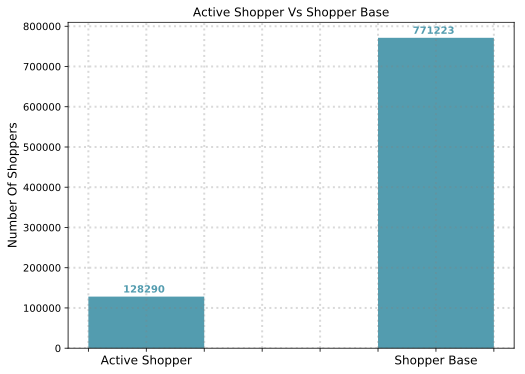

In [23]:
ind_width = 0.4

x = [1, 2]
y = [len(batches.shopper_id.unique()), len(metrics.shopper_id.unique())]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
# ax1.set_xlabel('Batch Tier',fontsize=12)
ax1.set_xticklabels(['', '', 'Active Shopper', '', '', '', '', 'Shopper Base', ''], fontsize=12)
ax1.set_ylabel('Number Of Shoppers',fontsize=12)
ax1.set_title('Active Shopper Vs Shopper Base')
for i, v in enumerate(y):
    ax1.text(i + 0.92, v + 10000, str(v), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

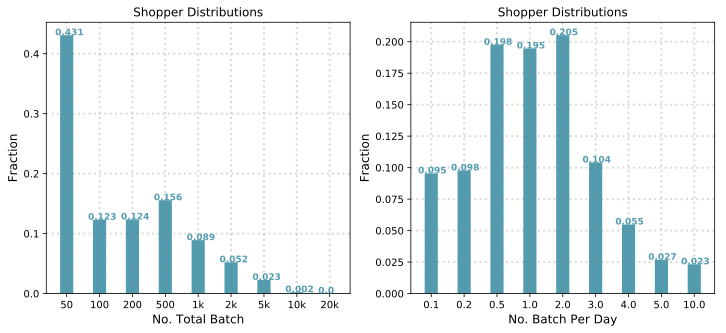

In [24]:
ind_width = 0.4

x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
batches_tier = batches[['total_batches_tier', 'shopper_id']]\
    .groupby('total_batches_tier').count().reset_index()\
    .rename(columns={'shopper_id':'shopper_count'})
tot_shopper = len(batches)
y = [i / float(tot_shopper) for i in batches_tier['shopper_count'].tolist()][:9]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('No. Total Batch',fontsize=12)
ax1.set_ylabel('Fraction',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('50', '100', '200', '500',
                     '1k', '2k', '5k', '10k', '20k'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=9)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

batches_perday_tier = batches[['batches_perday_tier', 'shopper_id']]\
    .groupby('batches_perday_tier').count().reset_index()\
    .rename(columns={'shopper_id':'shopper_count'})
tot_shopper = len(batches)
y2 = [i / float(tot_shopper) for i in batches_perday_tier['shopper_count'].tolist()][:9]
ax2= fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel('No. Batch Per Day',fontsize=12)
ax2.set_ylabel('Fraction',fontsize=12)
ax2.set_title('Shopper Distributions')
ax2.set_xticks(x)
ax2.set_xticklabels(('0.1', '0.2', '0.5', '1.0',
                     '2.0', '3.0', '4.0', '5.0', '10.0'), fontsize=10)
for i, v in enumerate(y2):
    ax2.text(i + 0.6, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=9)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

In [25]:
# Get shoppers and batches for T28
t_shoppers = batches[['tenure_tier', 't28_batches']].groupby('tenure_tier')\
    .count().reset_index().rename(columns={'t28_batches':'shopper_count'})
t_batches = batches[['tenure_tier', 't28_batches']].groupby('tenure_tier')\
    .sum().reset_index().rename(columns={'t28_batches':'batch_count'})
t28_shopper_batches = t_shoppers.merge(t_batches, on=['tenure_tier'])
t28_shopper_batches['t28_batch_per_shopper'] = t28_shopper_batches['batch_count']\
    / t28_shopper_batches['shopper_count']

batches_channel = batches[['tenure_tier', 'channel_simplified', 'shopper_id']]\
    .groupby(['tenure_tier', 'channel_simplified']).count().reset_index()\
    .rename(columns={'shopper_id':'sub_count'})

# Get channel percent
t_temp = batches[['tenure_tier','shopper_id']]\
    .groupby(['tenure_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'sub_tot'})

batches_channel = batches_channel.merge(t_temp, on=['tenure_tier'])
batches_channel['sub_pct'] = batches_channel['sub_count'] / batches_channel['sub_tot']

# Fix missing referral row for referral when tenure_tier = 8
channel = pd.DataFrame({'channel_simplified':['organic', 'paid', 'referral']})
days = pd.DataFrame({'tenure_tier':[i for i in range(1, 9)]})
channel['key'] = 0
days['key'] = 0
t_days = channel.merge(days, how='outer')

batches_channel = batches_channel.merge(t_days,
        on=['tenure_tier', 'channel_simplified'], how='outer')
batches_channel.fillna(0, inplace=True)
batches_channel.drop('key', axis=1, inplace=True)

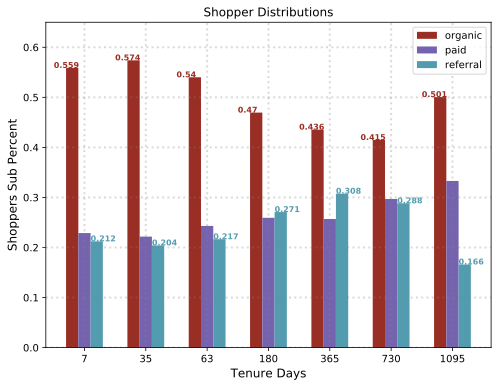

In [26]:
# xlabel_Range: 1: [0, 1], ..., 8:[7, 8]
# Tenure_so_far: 3:20, 4:54, 5:148, 6:403 7:1096
ind_width = 0.2

x = [i for i in range(1, 8)]
y1 = batches_channel[batches_channel['channel_simplified'] == 'organic']['sub_pct'].tolist()[:7]
y2 = batches_channel[batches_channel['channel_simplified'] == 'paid']['sub_pct'].tolist()[:7]
y3 = batches_channel[batches_channel['channel_simplified'] == 'referral']['sub_pct'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar([i - 0.2 for i in x], y1, align='center', color='#992E24', width=ind_width,
       label='organic')
ax1.bar([i for i in x], y2, align='center', color='#7663b0', width=ind_width,
       label='paid')
ax1.bar([i + 0.2 for i in x], y3, align='center', color='#539caf', width=ind_width,
       label='referral')
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
ax1.legend(loc='best')
for i, v in enumerate(y1):
    ax1.text(i + 0.5, v, str(round(v, 3)), color='#992E24', fontweight='bold', fontsize=8)
for i, v in enumerate(y3):
    ax1.text(i + 1.1, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=8)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 0.65])

plt.show()

In [27]:
# Understand tenure tier and batch/day tier

t_tot = batches[['tenure_tier', 'shopper_id']].groupby('tenure_tier').count()\
    .reset_index().rename(columns={'shopper_id':'shopper_count'})
t_sub = batches[['tenure_tier', 'batches_perday_tier2', 'shopper_id']]\
    .groupby(['tenure_tier', 'batches_perday_tier2']).count()\
    .reset_index().rename(columns={'shopper_id':'shopper_sub_count'})
tenure_batch_tier = t_sub.merge(t_tot, on='tenure_tier')
tenure_batch_tier['sub_pct'] = tenure_batch_tier['shopper_sub_count'] \
    / tenure_batch_tier['shopper_count']

df_tenure = pd.DataFrame({'tenure_tier':[1,2,3,4,5,6,7]})
df_t = pd.DataFrame({'batches_perday_tier2':[i for i in range(1, 5)]})

df_tenure['key'] = 0
df_t['key'] = 0

df_fix = df_tenure.merge(df_t, how='outer')

tenure_batch_tier = tenure_batch_tier.merge(df_fix, 
                    on=['tenure_tier', 'batches_perday_tier2'], how='outer')
tenure_batch_tier.fillna(0, inplace=True)
tenure_batch_tier.sort_values(by=['tenure_tier', 'batches_perday_tier2'], inplace=True)

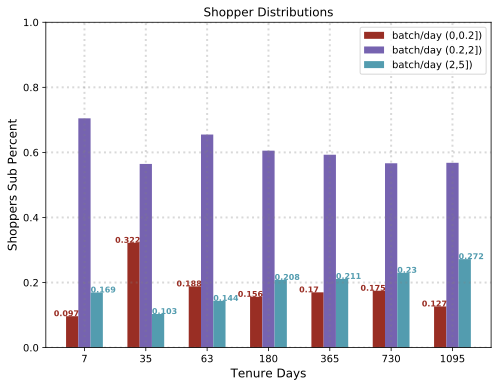

In [28]:
# xlabel_Range: 1: [0, 1], ..., 8:[7, 8]
# Tenure_so_far: 3:20, 4:54, 5:148, 6:403 7:1096
ind_width = 0.2

x = [i for i in range(1, 8)]
y1 = tenure_batch_tier[tenure_batch_tier['batches_perday_tier2'] == 1]['sub_pct'].tolist()[:7]
y2 = tenure_batch_tier[tenure_batch_tier['batches_perday_tier2'] == 2]['sub_pct'].tolist()[:7]
y3 = tenure_batch_tier[tenure_batch_tier['batches_perday_tier2'] == 3]['sub_pct'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar([i - 0.2 for i in x], y1, align='center', color='#992E24', width=ind_width,
       label='batch/day (0,0.2])')
ax1.bar([i for i in x], y2, align='center', color='#7663b0', width=ind_width,
       label='batch/day (0.2,2])')
ax1.bar([i + 0.2 for i in x], y3, align='center', color='#539caf', width=ind_width,
       label='batch/day (2,5])')
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.legend(loc='best')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y1):
    ax1.text(i + 0.5, v, str(round(v, 3)), color='#992E24', fontweight='bold', fontsize=8)
for i, v in enumerate(y3):
    ax1.text(i + 1.1, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=8)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 1])

plt.show()

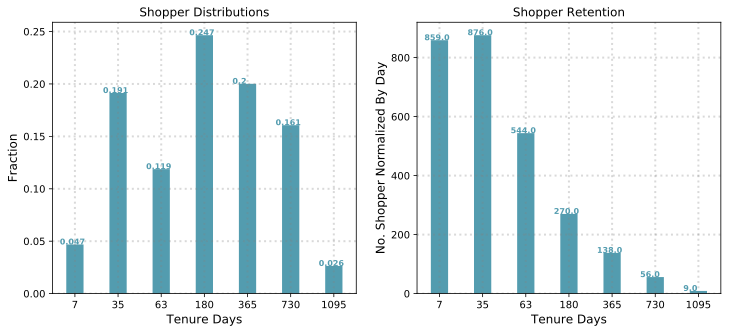

In [29]:
# xlabel_Range: 1: [0, 1], ..., 8:[7, 8]
# Tenure_so_far: 3:20, 4:54, 5:148, 6:403 7:1096
ind_width = 0.4

x = [i for i in range(1, 8)]
y = t28_shopper_batches['shopper_count'].tolist()[:7]
y1 = [i / float(tot_shopper) for i in y]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.bar(x, y1, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Fraction',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
if True:
    for i, v in enumerate(y1):
        ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=8)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

# Number of shopper by Tenure Tier
# Divided by the days in the Tier
y2 = [i / j for i, j in zip(y, [7, 28, 28, 117, 185, 365, 365])]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel('Tenure Days',fontsize=12)
ax2.set_ylabel('No. Shopper Normalized By Day',fontsize=12)
ax2.set_title('Shopper Retention')
ax2.set_xticks(x)
ax2.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
if True:
    for i, v in enumerate(y2):
        ax2.text(i + 0.65, v, str(round(v, 1)), color='#539caf', fontweight='bold', fontsize=8)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

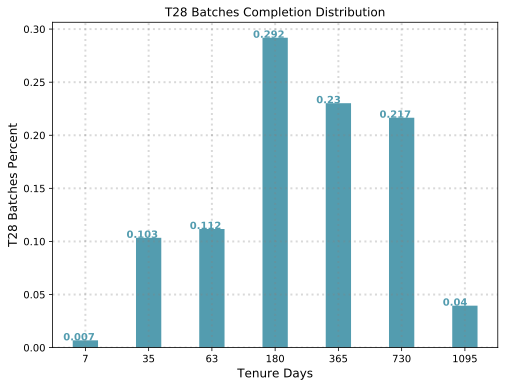

In [30]:
# xlabel_Range: 1: [0, 1], ..., 8:[7, 8]
# Tenure_so_far: 3:20, 4:54, 5:148, 6:403 7:1096
ind_width = 0.4

x = [i for i in range(1, 8)]
y = t28_shopper_batches['batch_count'].tolist()[:7]
y = [i / float(sum(y)) for i in y]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('T28 Batches Percent',fontsize=12)
ax1.set_title('T28 Batches Completion Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

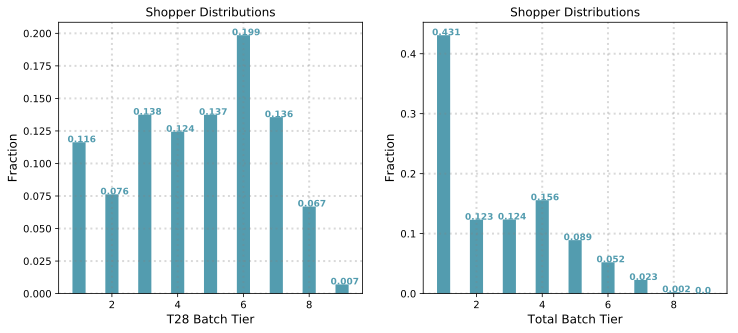

In [31]:
ind_width = 0.4

x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
t28_batches_tier = batches[['t28_batches_tier', 'shopper_id']]\
    .groupby('t28_batches_tier').count().reset_index()\
    .rename(columns={'shopper_id':'shopper_count'})
y = [i / float(tot_shopper) for i in t28_batches_tier['shopper_count'].tolist()][:9]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('T28 Batch Tier',fontsize=12)
ax1.set_ylabel('Fraction',fontsize=12)
ax1.set_title('Shopper Distributions')
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=9)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

x1 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
batches_tier = batches[['total_batches_tier', 'shopper_id']]\
    .groupby('total_batches_tier').count().reset_index()\
    .rename(columns={'shopper_id':'shopper_count'})
y1 = [i / float(tot_shopper) for i in batches_tier['shopper_count'].tolist()][:9]

ax2 = fig.add_subplot(122)
ax2.bar(x1, y1, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel('Total Batch Tier',fontsize=12)
ax2.set_ylabel('Fraction',fontsize=12)
ax2.set_title('Shopper Distributions')
for i, v in enumerate(y1):
    ax2.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=9)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

In [32]:
# Understand tenure tier and batch/day tier

t_tot = batches[['tenure_tier', 'shopper_id']].groupby('tenure_tier').count()\
    .reset_index().rename(columns={'shopper_id':'shopper_count'})
t_sub = batches[['tenure_tier', 't28_batches_tier2', 'shopper_id']]\
    .groupby(['tenure_tier', 't28_batches_tier2']).count()\
    .reset_index().rename(columns={'shopper_id':'shopper_sub_count'})
t28_batch_tier = t_sub.merge(t_tot, on='tenure_tier')
t28_batch_tier['sub_pct'] = t28_batch_tier['shopper_sub_count'] \
    / t28_batch_tier['shopper_count']

df_tenure = pd.DataFrame({'tenure_tier':[1,2,3,4,5,6,7]})
df_t = pd.DataFrame({'t28_batches_tier2':[i for i in range(1, 7)]})

df_tenure['key'] = 0
df_t['key'] = 0

df_fix = df_tenure.merge(df_t, how='outer')

t28_batch_tier = t28_batch_tier.merge(df_fix, 
                    on=['tenure_tier', 't28_batches_tier2'], how='outer')
t28_batch_tier.fillna(0, inplace=True)
t28_batch_tier.sort_values(by=['tenure_tier', 't28_batches_tier2'], inplace=True)

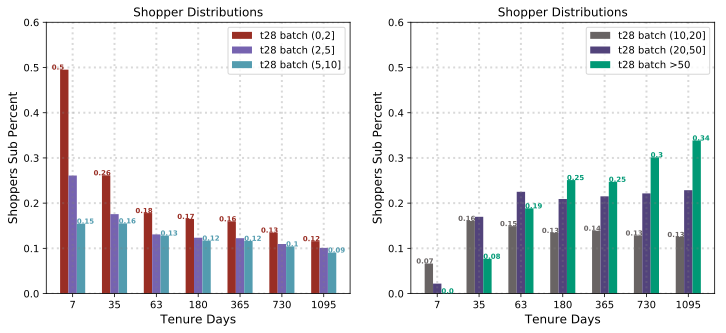

In [33]:
# xlabel_Range: 1: [0, 1], ..., 8:[7, 8]
# Tenure_so_far: 3:20, 4:54, 5:148, 6:403 7:1096
ind_width = 0.2

x = [i for i in range(1, 8)]
y1 = t28_batch_tier[t28_batch_tier['t28_batches_tier2'] == 1]['sub_pct'].tolist()[:7]
y2 = t28_batch_tier[t28_batch_tier['t28_batches_tier2'] == 2]['sub_pct'].tolist()[:7]
y3 = t28_batch_tier[t28_batch_tier['t28_batches_tier2'] == 3]['sub_pct'].tolist()[:7]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.bar([i - 0.2 for i in x], y1, align='center', color='#992E24', width=ind_width,
       label='t28 batch (0,2]')
ax1.bar([i for i in x], y2, align='center', color='#7663b0', width=ind_width,
       label='t28 batch (2,5]')
ax1.bar([i + 0.2 for i in x], y3, align='center', color='#539caf', width=ind_width,
       label='t28 batch (5,10]')
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.legend(loc='best')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y1):
    ax1.text(i + 0.5, v, str(round(v, 2)), color='#992E24', fontweight='bold', fontsize=7)
for i, v in enumerate(y3):
    ax1.text(i + 1.1, v, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 0.6])

##########
y4 = t28_batch_tier[t28_batch_tier['t28_batches_tier2'] == 4]['sub_pct'].tolist()[:7]
y5 = t28_batch_tier[t28_batch_tier['t28_batches_tier2'] == 5]['sub_pct'].tolist()[:7]
y6 = t28_batch_tier[t28_batch_tier['t28_batches_tier2'] == 6]['sub_pct'].tolist()[:7]
ax2 = fig.add_subplot(122)
ax2.bar([i - 0.2 for i in [1,2,3,4,5,6,7]], y4, align='center', color='#696464', width=ind_width,
       label='t28 batch (10,20]')
ax2.bar([i for i in [1,2,3,4,5,6,7]], y5, align='center', color='#52437b', width=ind_width,
       label='t28 batch (20,50]')
ax2.bar([i + 0.2 for i in [1,2,3,4,5,6,7]], y6, align='center', color='#009975', width=ind_width,
       label='t28 batch >50')
ax2.set_xlabel('Tenure Days',fontsize=12)
ax2.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax2.set_title('Shopper Distributions')
ax2.legend(loc='best')
ax2.set_xticks(x)
ax2.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y4):
    ax2.text(i + 0.5, v, str(round(v, 2)), color='#696464', fontweight='bold', fontsize=7)
for i, v in enumerate(y6):
    ax2.text(i + 1.1, v, str(round(v, 2)), color='#009975', fontweight='bold', fontsize=7)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.set_ylim([0, 0.6])

plt.show()

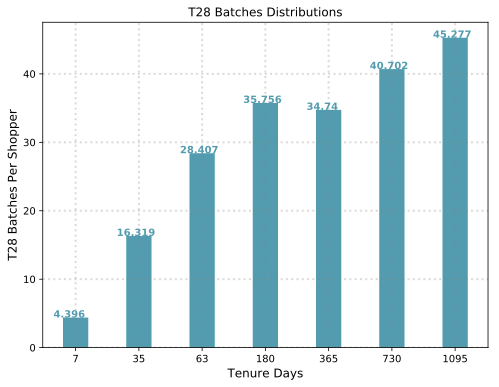

In [34]:
# 1: [0, 1], ..., 8:[7, 8]
ind_width = 0.4

x = [i for i in range(1, 8)]
y = t28_shopper_batches['t28_batch_per_shopper'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('T28 Batches Per Shopper',fontsize=12)
ax1.set_title('T28 Batches Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

In [35]:
if False: 
    fig = plt.figure(figsize=(8, 6))
    ax2 = fig.add_subplot(111)
    ax2.scatter(batches['tenure_so_far'], batches['running_total_batches'], color='#539caf')
    ax2.set_xlabel('Tenure in Days',fontsize=12)
    ax2.set_ylabel('Number of Batches',fontsize=12)
    ax2.set_title('Tenure Days Vs Batches')
    ax2.set_ylim([0, 15000])
    ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    plt.show()

In [36]:
if False:
    fig = plt.figure(figsize=(8, 6))
    ax2 = fig.add_subplot(111)
    ax2.scatter(batches['tenure_so_far'], batches['t28_batches'], color='#539caf')
    ax2.set_xlabel('Tenure in Days',fontsize=12)
    ax2.set_ylabel('T28 Batches',fontsize=12)
    ax2.set_title('Tenure Days Vs T28 Batches')
    # ax2.set_ylim([0, 15000])
    ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    plt.show()

In [37]:
if False:
    fig = plt.figure(figsize=(8, 6))
    ax2 = fig.add_subplot(111)
    ax2.scatter(batches['tenure_so_far'], batches['applied_to_activation'], color='#539caf')
    ax2.set_xlabel('Tenure in Days',fontsize=12)
    ax2.set_ylabel('Applied To Activation',fontsize=12)
    ax2.set_title('Tenure Days Vs Applied_Activation')
    ax2.set_ylim([0, 2000])
    ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    plt.show()

In [38]:
# About activation
activations = batches[['tenure_tier', 'activation_tier', 'shopper_id']]\
    .groupby(['tenure_tier', 'activation_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'sub_count'})

# Get channel percent
t_temp = batches[['tenure_tier','shopper_id']]\
    .groupby(['tenure_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'sub_tot'})

activations = activations.merge(t_temp, on=['tenure_tier'])
activations['sub_pct'] = activations['sub_count'] / activations['sub_tot']

# Fix missing referral row for referral when tenure_tier = 8
tier = pd.DataFrame({'activation_tier':[1, 2, 3]})
days = pd.DataFrame({'tenure_tier':[i for i in range(1, 9)]})
tier['key'] = 0
days['key'] = 0
t_days = tier.merge(days, how='outer')

activations = activations.merge(t_days,
        on=['tenure_tier', 'activation_tier'], how='outer')
activations.fillna(0, inplace=True)
activations.drop('key', axis=1, inplace=True)

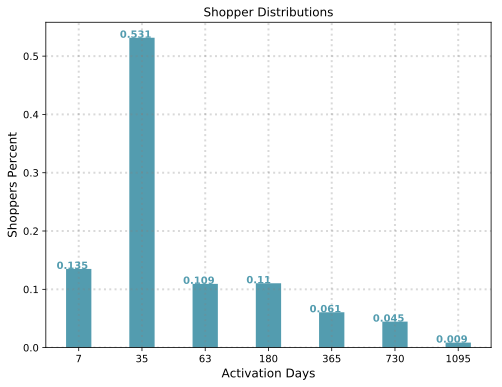

In [39]:
t_activation = batches[['activation_tier', 't28_batches']].groupby('activation_tier')\
    .count().reset_index().rename(columns={'t28_batches':'shopper_count'})

# xlabel_Range: 1: [0, 1], ..., 8:[7, 8]
# Tenure_so_far: 2:7, 3:20, 4:54, 5:148, 6:403 7:1096
ind_width = 0.4

x = [i for i in range(1, 8)]
y = t_activation['shopper_count'].tolist()[:7]
y = [i / float(sum(y)) for i in y]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Activation Days',fontsize=12)
ax1.set_ylabel('Shoppers Percent',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

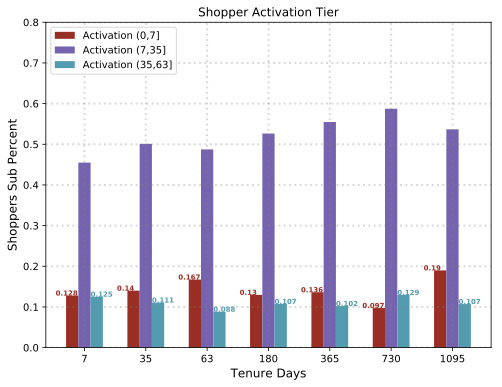

In [40]:
ind_width = 0.2

x = [i for i in range(1, 8)]
y1 = activations[activations['activation_tier'] == 1]['sub_pct'].tolist()[:7]
y2 = activations[activations['activation_tier'] == 2]['sub_pct'].tolist()[:7]
y3 = activations[activations['activation_tier'] == 3]['sub_pct'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar([i - 0.2 for i in x], y1, align='center', color='#992E24', width=ind_width,
       label='Activation (0,7]')
ax1.bar([i for i in x], y2, align='center', color='#7663b0', width=ind_width,
       label='Activation (7,35]')
ax1.bar([i + 0.2 for i in x], y3, align='center', color='#539caf', width=ind_width,
       label='Activation (35,63]')
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax1.set_title('Shopper Activation Tier')
ax1.set_ylim([0, 0.8])
ax1.legend(loc='upper left')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y1):
    ax1.text(i + 0.53, v, str(round(v, 3)), color='#992E24', fontweight='bold', fontsize=7)
for i, v in enumerate(y3):
    ax1.text(i + 1.1, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

In [41]:
shopper_group_metrics = batches[['tenure_tier', 'total_mpi', 'late_delivery_percentage',
                                'recent_hours_worked', 't30_reliability_incidents',
                                't30_top_rated_order_delivery_pct']]\
    .groupby(['tenure_tier']).agg({'total_mpi':np.mean, 'late_delivery_percentage':np.mean,
                                      'recent_hours_worked':np.mean,
                                      't30_reliability_incidents':np.mean,
                                      't30_top_rated_order_delivery_pct':np.mean})\
    .reset_index()

In [42]:
shopper_group_metrics

,tenure_tier,total_mpi,recent_hours_worked,t30_reliability_incidents,late_delivery_percentage,t30_top_rated_order_delivery_pct
0,1,3.158487,6.995660,0.568787,0.410765,0.504642
1,2,2.716461,25.739467,1.286114,0.358911,0.667461
2,3,2.134020,46.218942,2.020861,0.320191,0.815788
3,4,1.867902,51.549581,2.458854,0.320303,0.842388
4,5,1.739025,57.227441,3.033583,0.322322,0.859021
5,6,1.693452,66.704176,3.335032,0.349931,0.860172
6,7,1.648207,71.014063,3.273489,0.353400,0.857651
7,8,1.667867,70.451450,2.754098,0.310598,0.847793
8,9,1.615052,77.702842,2.614987,0.309723,0.849587


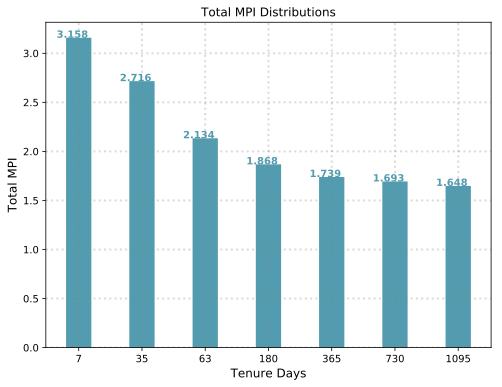

In [43]:
# 1: [0, 1], ..., 8:[7, 8]
ind_width = 0.4

x = [i for i in range(1, 8)]
y = shopper_group_metrics['total_mpi'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Total MPI',fontsize=12)
ax1.set_title('Total MPI Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

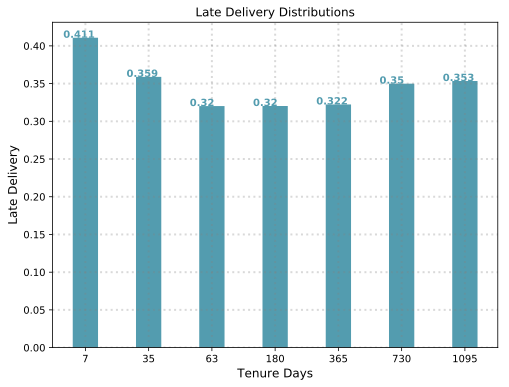

In [44]:
# 1: [0, 1], ..., 8:[7, 8]
ind_width = 0.4

x = [i for i in range(1, 8)]
y = shopper_group_metrics['late_delivery_percentage'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Late Delivery',fontsize=12)
ax1.set_title('Late Delivery Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

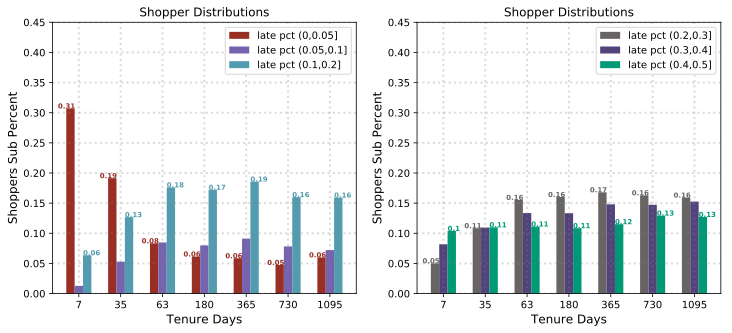

In [45]:
tenure_late_tier = batches[['tenure_tier', 'late_tier', 'shopper_id']]\
    .groupby(['tenure_tier', 'late_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'sub_num'})
t_late_tier = batches[['tenure_tier', 'shopper_id']]\
    .groupby(['tenure_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'tot_num'})
tenure_late_tier = tenure_late_tier.merge(t_late_tier, on=['tenure_tier'])
tenure_late_tier['sub_pct'] = tenure_late_tier['sub_num'] / tenure_late_tier['tot_num']

df_tenure = pd.DataFrame({'tenure_tier':[1,2,3,4,5,6,7]})
df_t = pd.DataFrame({'late_tier':[i for i in range(1, 7)]})

df_tenure['key'] = 0
df_t['key'] = 0

df_fix = df_tenure.merge(df_t, how='outer')

tenure_late_tier = tenure_late_tier.merge(df_fix, 
                    on=['tenure_tier', 'late_tier'], how='outer')
tenure_late_tier.fillna(0, inplace=True)
tenure_late_tier.sort_values(by=['tenure_tier', 'late_tier'], inplace=True)

ind_width = 0.2

x = [i for i in range(1, 8)]
y1 = tenure_late_tier[tenure_late_tier['late_tier'] == 1]['sub_pct'].tolist()[:7]
y2 = tenure_late_tier[tenure_late_tier['late_tier'] == 2]['sub_pct'].tolist()[:7]
y3 = tenure_late_tier[tenure_late_tier['late_tier'] == 3]['sub_pct'].tolist()[:7]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.bar([i - 0.2 for i in x], y1, align='center', color='#992E24', width=ind_width,
       label='late pct (0,0.05]')
ax1.bar([i for i in x], y2, align='center', color='#7663b0', width=ind_width,
       label='late pct (0.05,0.1]')
ax1.bar([i + 0.2 for i in x], y3, align='center', color='#539caf', width=ind_width,
       label='late pct (0.1,0.2]')
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax1.set_title('Shopper Distributions')
ax1.legend(loc='best')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y1):
    ax1.text(i + 0.5, v, str(round(v, 2)), color='#992E24', fontweight='bold', fontsize=7)
for i, v in enumerate(y3):
    ax1.text(i + 1.1, v, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 0.45])

##########
y4 = tenure_late_tier[tenure_late_tier['late_tier'] == 4]['sub_pct'].tolist()[:7]
y5 = tenure_late_tier[tenure_late_tier['late_tier'] == 5]['sub_pct'].tolist()[:7]
y6 = tenure_late_tier[tenure_late_tier['late_tier'] == 6]['sub_pct'].tolist()[:7]
ax2 = fig.add_subplot(122)
ax2.bar([i - 0.2 for i in [1,2,3,4,5,6,7]], y4, align='center', color='#696464', width=ind_width,
       label='late pct (0.2,0.3]')
ax2.bar([i for i in [1,2,3,4,5,6,7]], y5, align='center', color='#52437b', width=ind_width,
       label='late pct (0.3,0.4]')
ax2.bar([i + 0.2 for i in [1,2,3,4,5,6,7]], y6, align='center', color='#009975', width=ind_width,
       label='late pct (0.4,0.5]')
ax2.set_xlabel('Tenure Days',fontsize=12)
ax2.set_ylabel('Shoppers Sub Percent',fontsize=12)
ax2.set_title('Shopper Distributions')
ax2.legend(loc='best')
ax2.set_xticks(x)
ax2.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y4):
    ax2.text(i + 0.5, v, str(round(v, 2)), color='#696464', fontweight='bold', fontsize=7)
for i, v in enumerate(y6):
    ax2.text(i + 1.1, v, str(round(v, 2)), color='#009975', fontweight='bold', fontsize=7)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.set_ylim([0, 0.45])

plt.show()

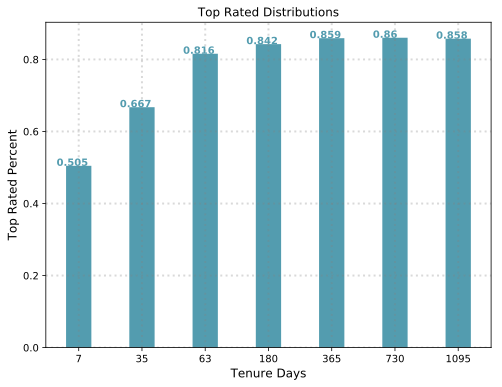

In [46]:
# 1: [0, 1], ..., 8:[7, 8]
ind_width = 0.4

x = [i for i in range(1, 8)]
y = shopper_group_metrics['t30_top_rated_order_delivery_pct'].tolist()[:7]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Tenure Days',fontsize=12)
ax1.set_ylabel('Top Rated Percent',fontsize=12)
ax1.set_title('Top Rated Distributions')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y):
    ax1.text(i + 0.65, v, str(round(v, 3)), color='#539caf', fontweight='bold', fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

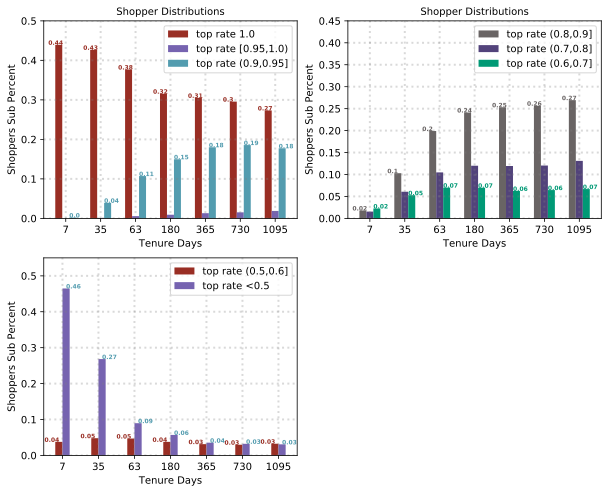

In [47]:
tenure_rate_tier = batches[['tenure_tier', 't30_rate_tier', 'shopper_id']]\
    .groupby(['tenure_tier', 't30_rate_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'sub_num'})
t_rate_tier = batches[['tenure_tier', 'shopper_id']]\
    .groupby(['tenure_tier']).count().reset_index()\
    .rename(columns={'shopper_id':'tot_num'})
tenure_rate_tier = tenure_rate_tier.merge(t_rate_tier, on=['tenure_tier'])
tenure_rate_tier['sub_pct'] = tenure_rate_tier['sub_num'] / tenure_rate_tier['tot_num']

df_tenure = pd.DataFrame({'tenure_tier':[1,2,3,4,5,6,7]})
df_t = pd.DataFrame({'t30_rate_tier':[i for i in range(1, 9)]})

df_tenure['key'] = 0
df_t['key'] = 0

df_fix = df_tenure.merge(df_t, how='outer')

tenure_rate_tier = tenure_rate_tier.merge(df_fix, 
                    on=['tenure_tier', 't30_rate_tier'], how='outer')
tenure_rate_tier.fillna(0, inplace=True)
tenure_rate_tier.sort_values(by=['tenure_tier', 't30_rate_tier'], inplace=True)

ind_width = 0.2

x = [i for i in range(1, 8)]
y1 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 1]['sub_pct'].tolist()[:7]
y2 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 2]['sub_pct'].tolist()[:7]
y3 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 3]['sub_pct'].tolist()[:7]

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221)
ax1.bar([i - 0.2 for i in x], y1, align='center', color='#992E24', width=ind_width,
       label='top rate 1.0')
ax1.bar([i for i in x], y2, align='center', color='#7663b0', width=ind_width,
       label='top rate [0.95,1.0)')
ax1.bar([i + 0.2 for i in x], y3, align='center', color='#539caf', width=ind_width,
       label='top rate (0.9,0.95]')
ax1.set_xlabel('Tenure Days',fontsize=10)
ax1.set_ylabel('Shoppers Sub Percent',fontsize=10)
ax1.set_title('Shopper Distributions',fontsize=10)
ax1.legend(loc='best')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y1):
    ax1.text(i + 0.5, v, str(round(v, 2)), color='#992E24', fontweight='bold', fontsize=6)
for i, v in enumerate(y3):
    ax1.text(i + 1.1, v, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=6)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 0.5])

##########
y4 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 4]['sub_pct'].tolist()[:7]
y5 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 5]['sub_pct'].tolist()[:7]
y6 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 6]['sub_pct'].tolist()[:7]
ax2 = fig.add_subplot(222)
ax2.bar([i - 0.2 for i in [1,2,3,4,5,6,7]], y4, align='center', color='#696464', width=ind_width,
       label='top rate (0.8,0.9]')
ax2.bar([i for i in [1,2,3,4,5,6,7]], y5, align='center', color='#52437b', width=ind_width,
       label='top rate (0.7,0.8]')
ax2.bar([i + 0.2 for i in [1,2,3,4,5,6,7]], y6, align='center', color='#009975', width=ind_width,
       label='top rate (0.6,0.7]')
ax2.set_xlabel('Tenure Days',fontsize=10)
ax2.set_ylabel('Shoppers Sub Percent',fontsize=10)
ax2.set_title('Shopper Distributions',fontsize=10)
ax2.legend(loc='best')
ax2.set_xticks(x)
ax2.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y4):
    ax2.text(i + 0.5, v, str(round(v, 2)), color='#696464', fontweight='bold', fontsize=6)
for i, v in enumerate(y6):
    ax2.text(i + 1.1, v, str(round(v, 2)), color='#009975', fontweight='bold', fontsize=6)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.set_ylim([0, 0.45])

y7 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 7]['sub_pct'].tolist()[:7]
y8 = tenure_rate_tier[tenure_rate_tier['t30_rate_tier'] == 8]['sub_pct'].tolist()[:7]
ax3 = fig.add_subplot(223)
ax3.bar([i - 0.1 for i in x], y7, align='center', color='#992E24', width=ind_width,
       label='top rate (0.5,0.6]')
ax3.bar([i + 0.1 for i in x], y8, align='center', color='#7663b0', width=ind_width,
       label='top rate <0.5')
ax3.set_xlabel('Tenure Days',fontsize=10)
ax3.set_ylabel('Shoppers Sub Percent',fontsize=10)
ax3.legend(loc='best')
ax3.set_xticks(x)
ax3.set_xticklabels(('7', '35', '63', '180', 
                     '365', '730', '1095'), fontsize=10)
for i, v in enumerate(y7):
    ax3.text(i + 0.5, v, str(round(v, 2)), color='#992E24', fontweight='bold', fontsize=6)
for i, v in enumerate(y8):
    ax3.text(i + 1.1, v, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=6)
ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax3.set_ylim([0, 0.55])

plt.show()

### Save contribution File

In [48]:
# Save to CSV
contribution_scores = contribution_scores.drop('activation_day', axis=1)\
    .merge(batches, on=['shopper_id'])
contribution_scores[['shopper_id', 'contribution_normed', 'total_mpi', 
    't28_batches', 't30_reliability_incidents', 'tenure', 
                    'tenure_tier']].to_csv(save_contribution_file, index=False)